<a href="https://colab.research.google.com/github/hsuanchengsun/Natural-Language-Processing/blob/main/Topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Topic modeling

## Section 1: Prepare Data




In [ ]:
# The imports needed for this notebook
import numpy as np

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

from sklearn import decomposition
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, wordpunct_tokenize
nltk.download('punkt') 
# nltk.download('averaged_perceptron_tagger') 
from nltk.corpus import stopwords
nltk.download('stopwords')

import string
from string import punctuation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Setup access to my Google Drive
from google.colab import drive
drive.mount('/content/drive',  force_remount=False)

Mounted at /content/drive


In [ ]:
# read a local csv file into Pandas DataFrame
# The file is from Lab 3 Section 1
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Mydata/restaurant_review_row.csv", index_col = 0)
df.head(3)

,Cust_Rating,Datetime,Review,Resturant,City,State,Zipcode,Business_Rating_Score,Review_expanded,Review_Token,Review_tagged,Review_lemmas,Review_lemmas_final,Cleaned_review_lemma
0,5.0,2008-09-29 09:33:04,its the best pizza hut i'v found in florida al...,Pizza Hut,Orlando,FL,32819,3.5,its the best pizza hut i'v found in florida al...,"['its', 'the', 'best', 'pizza', 'hut', 'i', ""'...","[('its', 'PRP$'), ('the', 'DT'), ('best', 'JJS...","['its', 'the', 'best', 'pizza', 'hut', 'i', ""'...","['best', 'pizza', 'hut', 'find', 'florida', 'a...",best pizza hut find florida always get great d...
1,3.0,2013-12-06 23:22:26,"This place is an interesting combo. The chef, ...",La Mongerie Bakery & Bistro,Atlanta,GA,30308,3.0,"This place is an interesting combo. The chef, ...","['This', 'place', 'is', 'an', 'interesting', '...","[('This', 'DT'), ('place', 'NN'), ('is', 'VBZ'...","['This', 'place', 'be', 'an', 'interesting', '...","['place', 'interesting', 'combo', 'chef', 'dav...",place interesting combo chef david incredible ...
2,5.0,2008-11-16 09:44:04,Pizza Hut is great! You get huge pizzas for yo...,Pizza Hut,Orlando,FL,32819,3.5,Pizza Hut is great! You get huge pizzas for yo...,"['Pizza', 'Hut', 'is', 'great', '!', 'You', 'g...","[('Pizza', 'NNP'), ('Hut', 'NNP'), ('is', 'VBZ...","['Pizza', 'Hut', 'be', 'great', '!', 'You', 'g...","['pizza', 'hut', 'great', 'get', 'huge', 'pizz...",pizza hut great get huge pizza money service q...


In [ ]:
# final number of rows in the cleaned dataframe
print("final number of rows in the cleaned dataframe: ", len(df))

final number of rows in the cleaned dataframe:  63230


In [ ]:
# Test to see if there was any empty reviews in the dataset
df['Cleaned_review_lemma'].isnull().values.any()

True

In [ ]:
# Check Null rows
df[df['Cleaned_review_lemma'].isnull()]

,Cust_Rating,Datetime,Review,Resturant,City,State,Zipcode,Business_Rating_Score,Review_expanded,Review_Token,Review_tagged,Review_lemmas,Review_lemmas_final,Cleaned_review_lemma
2820,1.0,2012-11-29 23:24:50,dont go,Coconut Thai Cafe,Wellesley,MA,02481,3.5,do not go,"['do', 'not', 'go']","[('do', 'VB'), ('not', 'RB'), ('go', 'VB')]","['do', 'not', 'go']",[],NaN


In [ ]:
# Drop null rows
df.dropna(subset = ['Cleaned_review_lemma'], inplace = True)

In [ ]:
# Test to see if there was any empty reviews in the dataset
df['Cleaned_review_lemma'].isnull().values.any()

False

In [ ]:
# final number of rows in the cleaned dataframe
print("final number of rows in the cleaned dataframe: ", len(df))

final number of rows in the cleaned dataframe:  63229


### Check tokens have digits or punctuations and remove them

In [ ]:
# tokenize 
df['review_token'] = df['Cleaned_review_lemma'].apply(lambda row:wordpunct_tokenize(row))
df.head(3)

,Cust_Rating,Datetime,Review,Resturant,City,State,Zipcode,Business_Rating_Score,Review_expanded,Review_Token,Review_tagged,Review_lemmas,Review_lemmas_final,Cleaned_review_lemma,review_token
0,5.0,2008-09-29 09:33:04,its the best pizza hut i'v found in florida al...,Pizza Hut,Orlando,FL,32819,3.5,its the best pizza hut i'v found in florida al...,"['its', 'the', 'best', 'pizza', 'hut', 'i', ""'...","[('its', 'PRP$'), ('the', 'DT'), ('best', 'JJS...","['its', 'the', 'best', 'pizza', 'hut', 'i', ""'...","['best', 'pizza', 'hut', 'find', 'florida', 'a...",best pizza hut find florida always get great d...,"[best, pizza, hut, find, florida, always, get,..."
1,3.0,2013-12-06 23:22:26,"This place is an interesting combo. The chef, ...",La Mongerie Bakery & Bistro,Atlanta,GA,30308,3.0,"This place is an interesting combo. The chef, ...","['This', 'place', 'is', 'an', 'interesting', '...","[('This', 'DT'), ('place', 'NN'), ('is', 'VBZ'...","['This', 'place', 'be', 'an', 'interesting', '...","['place', 'interesting', 'combo', 'chef', 'dav...",place interesting combo chef david incredible ...,"[place, interesting, combo, chef, david, incre..."
2,5.0,2008-11-16 09:44:04,Pizza Hut is great! You get huge pizzas for yo...,Pizza Hut,Orlando,FL,32819,3.5,Pizza Hut is great! You get huge pizzas for yo...,"['Pizza', 'Hut', 'is', 'great', '!', 'You', 'g...","[('Pizza', 'NNP'), ('Hut', 'NNP'), ('is', 'VBZ...","['Pizza', 'Hut', 'be', 'great', '!', 'You', 'g...","['pizza', 'hut', 'great', 'get', 'huge', 'pizz...",pizza hut great get huge pizza money service q...,"[pizza, hut, great, get, huge, pizza, money, s..."


In [ ]:
# count the frequency of each unique token in the cleaned review
from nltk import FreqDist

# use FreqDis() to find the frequency disctibution for each token
%time fdist_reviews= FreqDist([token for sublist in df['review_token'].values for token in sublist])
print('The total number of tokens:',fdist_reviews.N())
print('The number of unique tokens:', len(fdist_reviews))

CPU times: user 2.36 s, sys: 16.8 ms, total: 2.38 s
Wall time: 2.4 s
The total number of tokens: 3199888
The number of unique tokens: 46500


In [ ]:
# let's sort the items based on the frequency count
fdist_reviews_list = sorted(fdist_reviews.items(), key=lambda x:x[1], reverse= True)

In [ ]:
# create a list of tokens
token_list = [token[0] for token in fdist_reviews_list]

In [ ]:
# let's see if any tokens are not characters 
none_char_token = [token for token in token_list if all(j.isdigit() or j in string.punctuation for j in token)]

print(len(none_char_token))
print(*none_char_token)

1080
... .... !!! !!!! ..... !). ??? !!!!! ...... !), :// --- :-) *** ?). )... !!!!!! ???? ...) ....... "... ..." ?), ?!? .). (?) ........ !!!!!!! !!) ????? :-( "). :). ...). ?!?! ?". |||||||||||||||| !". ;-) ......... **** ,,, !!!!!!!! "), ,... (!) .), ?!" ?!! ??) !!!) $$$ ...), (~$ ...( ).. !... !!). :(. ).... ***** ...? !?! ".... ---- ...." ?... )-- ?????? '... !!" .......... !!!!!!!!! ??????? !!), )!! ??! ?!) ?", ???) "-- ??" ...$ ..) ??!! ,.. ,,,, +++ !!!!!!!!!! (?). !!. )!!! ?!?!? !?!? !", "..... ----- ?!?) .." :-/ !!!. .** .!!! ..? :-). ............ $$. ___ !!!!) !.. .!! !?) ........... ...! |||||||||||| ....$ !!!" _____ !!!!!!!!!!!! (!). .". !?" ???????????? ?!!! !?? $$$. ?!). === (+$ ".. ....) !.... ..., .............. ;). ..! ??). ....? (... ?.... ..). [+] )). ...!!! |||||||| !!.. !!, ?????????? (?), .., (??) "!! !!!, ?-- (!), '.... ?!?!?! :)) '). !!!!!!!!!!! ...!! ???). ???" ..( !!!). ;-). !!... !!!... (???). *). ?!!? $$, :'( ............. ??????????? ....." ?"... ...". (!!)

In [ ]:
# let's create a cleaned set of tokens
df['review_cleaned_token'] = df['review_token'].apply(lambda row:[word for word in row if word not in none_char_token])
df.head(3)

,Cust_Rating,Datetime,Review,Resturant,City,State,Zipcode,Business_Rating_Score,Review_expanded,Review_Token,Review_tagged,Review_lemmas,Review_lemmas_final,Cleaned_review_lemma,review_token,review_cleaned_token
0,5.0,2008-09-29 09:33:04,its the best pizza hut i'v found in florida al...,Pizza Hut,Orlando,FL,32819,3.5,its the best pizza hut i'v found in florida al...,"['its', 'the', 'best', 'pizza', 'hut', 'i', ""'...","[('its', 'PRP$'), ('the', 'DT'), ('best', 'JJS...","['its', 'the', 'best', 'pizza', 'hut', 'i', ""'...","['best', 'pizza', 'hut', 'find', 'florida', 'a...",best pizza hut find florida always get great d...,"[best, pizza, hut, find, florida, always, get,...","[best, pizza, hut, find, florida, always, get,..."
1,3.0,2013-12-06 23:22:26,"This place is an interesting combo. The chef, ...",La Mongerie Bakery & Bistro,Atlanta,GA,30308,3.0,"This place is an interesting combo. The chef, ...","['This', 'place', 'is', 'an', 'interesting', '...","[('This', 'DT'), ('place', 'NN'), ('is', 'VBZ'...","['This', 'place', 'be', 'an', 'interesting', '...","['place', 'interesting', 'combo', 'chef', 'dav...",place interesting combo chef david incredible ...,"[place, interesting, combo, chef, david, incre...","[place, interesting, combo, chef, david, incre..."
2,5.0,2008-11-16 09:44:04,Pizza Hut is great! You get huge pizzas for yo...,Pizza Hut,Orlando,FL,32819,3.5,Pizza Hut is great! You get huge pizzas for yo...,"['Pizza', 'Hut', 'is', 'great', '!', 'You', 'g...","[('Pizza', 'NNP'), ('Hut', 'NNP'), ('is', 'VBZ...","['Pizza', 'Hut', 'be', 'great', '!', 'You', 'g...","['pizza', 'hut', 'great', 'get', 'huge', 'pizz...",pizza hut great get huge pizza money service q...,"[pizza, hut, great, get, huge, pizza, money, s...","[pizza, hut, great, get, huge, pizza, money, s..."


In [ ]:
# repeat the process to see our current token list 
%time fdist_reviews= FreqDist([token for sublist in df['review_cleaned_token'].values for token in sublist])
print('The total number of tokens:',fdist_reviews.N())
print('The number of unique tokens:', len(fdist_reviews))

CPU times: user 2.37 s, sys: 27.8 ms, total: 2.4 s
Wall time: 2.42 s
The total number of tokens: 3173287
The number of unique tokens: 45420


In [ ]:
# let's sort the items based on the frequency count
fdist_reviews_list = sorted(fdist_reviews.items(), key=lambda x:x[1], reverse= True)

In [ ]:
# create a list of tokens
token_list = [token[0] for token in fdist_reviews_list]

In [ ]:
# let's see if any tokens are not characters 
none_char_token = [token for token in token_list if all(j.isdigit() or j in string.punctuation for j in token)]

print(len(none_char_token))
print(*none_char_token)

0



In [ ]:
# Test to see if there was any empty reviews in the dataset
df['review_cleaned_token'].isnull().values.any()

False

### Final output

In [ ]:
df['review_final'] = df['review_cleaned_token'].apply(lambda row:' '.join(row))
df.head(3)

,Cust_Rating,Datetime,Review,Resturant,City,State,Zipcode,Business_Rating_Score,Review_expanded,Review_Token,Review_tagged,Review_lemmas,Review_lemmas_final,Cleaned_review_lemma,review_token,review_cleaned_token,review_final
0,5.0,2008-09-29 09:33:04,its the best pizza hut i'v found in florida al...,Pizza Hut,Orlando,FL,32819,3.5,its the best pizza hut i'v found in florida al...,"['its', 'the', 'best', 'pizza', 'hut', 'i', ""'...","[('its', 'PRP$'), ('the', 'DT'), ('best', 'JJS...","['its', 'the', 'best', 'pizza', 'hut', 'i', ""'...","['best', 'pizza', 'hut', 'find', 'florida', 'a...",best pizza hut find florida always get great d...,"[best, pizza, hut, find, florida, always, get,...","[best, pizza, hut, find, florida, always, get,...",best pizza hut find florida always get great d...
1,3.0,2013-12-06 23:22:26,"This place is an interesting combo. The chef, ...",La Mongerie Bakery & Bistro,Atlanta,GA,30308,3.0,"This place is an interesting combo. The chef, ...","['This', 'place', 'is', 'an', 'interesting', '...","[('This', 'DT'), ('place', 'NN'), ('is', 'VBZ'...","['This', 'place', 'be', 'an', 'interesting', '...","['place', 'interesting', 'combo', 'chef', 'dav...",place interesting combo chef david incredible ...,"[place, interesting, combo, chef, david, incre...","[place, interesting, combo, chef, david, incre...",place interesting combo chef david incredible ...
2,5.0,2008-11-16 09:44:04,Pizza Hut is great! You get huge pizzas for yo...,Pizza Hut,Orlando,FL,32819,3.5,Pizza Hut is great! You get huge pizzas for yo...,"['Pizza', 'Hut', 'is', 'great', '!', 'You', 'g...","[('Pizza', 'NNP'), ('Hut', 'NNP'), ('is', 'VBZ...","['Pizza', 'Hut', 'be', 'great', '!', 'You', 'g...","['pizza', 'hut', 'great', 'get', 'huge', 'pizz...",pizza hut great get huge pizza money service q...,"[pizza, hut, great, get, huge, pizza, money, s...","[pizza, hut, great, get, huge, pizza, money, s...",pizza hut great get huge pizza money service q...


In [ ]:
# save the file
df.to_pickle("/content/drive/MyDrive/Colab Notebooks/Mydata/L5_review_final")

## Section 2: Prepare dictionary and corpus for Gensim

In [ ]:
# The imports needed for this notebook
import numpy as np

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

from sklearn import decomposition
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Setup access to my Google Drive
from google.colab import drive
drive.mount('/content/drive',  force_remount=False)

Mounted at /content/drive


In [ ]:
# read a local csv file into Pandas DataFrame
df = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/Mydata/L5_review_final")
df.head(3)

,Cust_Rating,Datetime,Review,Resturant,City,State,Zipcode,Business_Rating_Score,Review_expanded,Review_Token,Review_tagged,Review_lemmas,Review_lemmas_final,Cleaned_review_lemma,review_token,review_cleaned_token,review_final
0,5.0,2008-09-29 09:33:04,its the best pizza hut i'v found in florida al...,Pizza Hut,Orlando,FL,32819,3.5,its the best pizza hut i'v found in florida al...,"['its', 'the', 'best', 'pizza', 'hut', 'i', ""'...","[('its', 'PRP$'), ('the', 'DT'), ('best', 'JJS...","['its', 'the', 'best', 'pizza', 'hut', 'i', ""'...","['best', 'pizza', 'hut', 'find', 'florida', 'a...",best pizza hut find florida always get great d...,"[best, pizza, hut, find, florida, always, get,...","[best, pizza, hut, find, florida, always, get,...",best pizza hut find florida always get great d...
1,3.0,2013-12-06 23:22:26,"This place is an interesting combo. The chef, ...",La Mongerie Bakery & Bistro,Atlanta,GA,30308,3.0,"This place is an interesting combo. The chef, ...","['This', 'place', 'is', 'an', 'interesting', '...","[('This', 'DT'), ('place', 'NN'), ('is', 'VBZ'...","['This', 'place', 'be', 'an', 'interesting', '...","['place', 'interesting', 'combo', 'chef', 'dav...",place interesting combo chef david incredible ...,"[place, interesting, combo, chef, david, incre...","[place, interesting, combo, chef, david, incre...",place interesting combo chef david incredible ...
2,5.0,2008-11-16 09:44:04,Pizza Hut is great! You get huge pizzas for yo...,Pizza Hut,Orlando,FL,32819,3.5,Pizza Hut is great! You get huge pizzas for yo...,"['Pizza', 'Hut', 'is', 'great', '!', 'You', 'g...","[('Pizza', 'NNP'), ('Hut', 'NNP'), ('is', 'VBZ...","['Pizza', 'Hut', 'be', 'great', '!', 'You', 'g...","['pizza', 'hut', 'great', 'get', 'huge', 'pizz...",pizza hut great get huge pizza money service q...,"[pizza, hut, great, get, huge, pizza, money, s...","[pizza, hut, great, get, huge, pizza, money, s...",pizza hut great get huge pizza money service q...


### Create dictionary that includes both unigrams and bigrams

In [ ]:
# The imports needed for this section
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases, Phraser

In [ ]:
# create a stream of sentences (a list of list of words) from the original text
sent = [text.split() for text in df['review_final']] 

# train a bigram model from the stream of sentences. We set min_count as 25 here. 
bigram = Phrases(sent, min_count=25)

# export the trained bigram model
# Use this instead of Phrases because we do not need to update the bigram statistics any more.
bigram_phraser = Phraser(bigram) 

In [ ]:
# apply the exported model to each review of the corpus
texts = bigram_phraser[sent]

texts[2] # note - this is the same as the Texts object that we defined in 1.6, but included bigram phrases. 

['pizza_hut',
 'great',
 'get',
 'huge',
 'pizza',
 'money',
 'service',
 'quick',
 'friendly',
 'breadstick',
 'starter',
 'delicious',
 'get',
 'huge',
 'drink',
 'seat',
 'quickly',
 'food',
 'deliver',
 'quickly',
 'great',
 'meal']

In [ ]:
# let's first created a list of bigram phrases
bigrams = []
for text in texts:
  for word in text: 
    if '_' in word:
      bigrams.append(word)

bigrams [:5] # see five bigrams

['pizza_hut', 'staff_friendly', 'feel_welcome', 'pizza_hut', 'staff_friendly']

In [ ]:
# check number of bigrams detected
len(bigrams)

180076

In [ ]:
# build id2word dictionary, assign integer id to each unique token, including bigrams
id2word = Dictionary(texts)

# let's check what is in the dictionary 
dict(list(id2word.items())[0: 3]) 

{0: 'always', 1: 'best', 2: 'child'}

In [ ]:
# check size of id2word
len(id2word)

46871

### Filter very frequent and rare tokens 

In [ ]:
# filter out tokens that appear in less than 60 documents (1% of our corpus documents), more than 0.5 documents (total corpus size, not absolute)
id2word.filter_extremes(no_below=60, no_above=0.5) 

# create a corpus, which here is the BOW bigram model, same as the doc_term_frequency we discussed early  
corpus = [id2word.doc2bow(doc) for doc in texts]

# corpus as list of list with tuples of (token_id, frequency) example
print(*corpus[3])

(0, 1) (10, 1) (16, 1) (47, 1) (53, 1) (71, 1) (72, 1)


In [ ]:
# check size of id2word
len(id2word)

4068

In [ ]:
# let's check what is in the dictionary 
for key, value in sorted(id2word.items())[:5]:
  print(key, value) 

0 always
1 best
2 child
3 deal
4 extra


## Section 3: LSA with BOW

In [ ]:
# The imports needed for this section
import gensim
from gensim import corpora
from gensim import models
from gensim.models import TfidfModel, LsiModel
from gensim.models import CoherenceModel # for evaluation

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

### Select topic numbers based on coherence scores

In [ ]:
# define evaluation model
def compute_coherence_scores (id2word, corpus, texts, stop, start, step):
  """
  Input:  id2word: a dictionary that maps token ID to tokens
          corpus: output from TfidfModel 
          texts: a list of list strings, tokenized texts
          stop: Max number of topics 
          start: Min number of topics
          step: number of topics to increment 
  Output: model_list: a list of LSA topic models 
          coherence_score: a list of coherence scores for each topic model
  """
  coherence_score = []
  model_list = []

  for n_topics in range (start, stop, step):
    lsa_model = models.LsiModel(corpus, # we will use tfidf
                                id2word=id2word,
                                num_topics=n_topics)
    
    model_list.append(lsa_model)
    
    coherence_model_lsa = CoherenceModel(model=lsa_model, texts=texts, dictionary=id2word, coherence='c_v')
    
    coherence_score.append(coherence_model_lsa.get_coherence())
  
  return model_list, coherence_score

In [ ]:
# we start with model with 2 topics, then with 4, 6, 8 topics
%time lsa_models = compute_coherence_scores(id2word, corpus, texts, stop=10, start=2, step=2) 

CPU times: user 2min 2s, sys: 7.45 s, total: 2min 9s
Wall time: 1min 58s


In [ ]:
lsa_models[1]

[0.3608575613437925,
 0.3902974640014818,
 0.3793692035007889,
 0.38100644554672713]

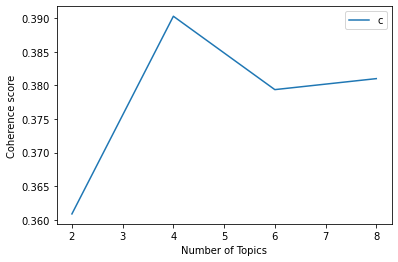

In [ ]:
# the plot shows that the number of topics based on coherence scores

x = range(2, 10, 2)
plt.plot(x, lsa_models[1])
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Define LSA with BOW function
def create_gensim_lsa_BOW (corpus, id2word, n_topics, n_words):
  """
  Input:  corpus: doc_term_matrix
          is2word: dictionary 
          number of topics, and number of words associated with each topic
  output: return LSA model
  """
  lsa_model = models.LsiModel(corpus,
                            id2word=id2word,
                            num_topics=n_topics)
  
  for index, value in lsa_model.print_topics(num_topics=n_topics, num_words=n_words):
    print('Topic ', index, ':', value)
  
  return lsa_model

### LSA BOW model with 4 topics

In [ ]:
# the LSA model with 4 topics
%time gensim_lsa_4 = create_gensim_lsa_BOW(corpus, id2word, 4, 10)

print(gensim_lsa_4)

Topic  0 : 0.308*"food" + 0.281*"order" + 0.279*"get" + 0.270*"good" + 0.248*"place" + 0.179*"like" + 0.173*"would" + 0.165*"one" + 0.144*"come" + 0.130*"time"
Topic  1 : -0.602*"order" + 0.433*"good" + 0.237*"place" + 0.218*"great" + 0.191*"food" + -0.152*"say" + -0.147*"get" + -0.144*"ask" + -0.121*"take" + -0.119*"tell"
Topic  2 : 0.809*"food" + -0.284*"pizza" + -0.195*"get" + -0.170*"like" + 0.140*"order" + -0.140*"place" + -0.132*"good" + 0.125*"service" + -0.107*"one" + 0.087*"restaurant"
Topic  3 : -0.544*"order" + -0.514*"good" + 0.405*"get" + -0.330*"pizza" + 0.126*"one" + 0.089*"say" + 0.081*"ask" + 0.080*"like" + -0.077*"chicken" + 0.076*"table"
CPU times: user 7.66 s, sys: 1.73 s, total: 9.4 s
Wall time: 5.77 s
LsiModel(num_terms=4068, num_topics=4, decay=1.0, chunksize=20000)


In [ ]:
# let's create a dataframe that shows each topic, its top 10 words, and its value
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(gensim_lsa_4.get_topics()): # the term topic matrix with shape (num_topics, vocabulary_size)
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [id2word[id] for id in top_feature_ids]
    labels= [('Topic'+str(i)+' word'), ('Topic'+str(i)+' value') ]
    topic_df = pd.DataFrame(zip(words, feature_values), columns=labels)
    topic_words = pd.concat([topic_words, topic_df], axis=1)

topic_words

,Topic0 word,Topic0 value,Topic1 word,Topic1 value,Topic2 word,Topic2 value,Topic3 word,Topic3 value
0,food,0.307803,good,0.433293,food,0.809239,get,0.405218
1,order,0.280649,place,0.237005,order,0.140048,one,0.125753
2,get,0.278729,great,0.218328,service,0.125204,say,0.088965
3,good,0.270202,food,0.190723,restaurant,0.087418,ask,0.081130
4,place,0.247732,really,0.092208,great,0.058309,like,0.079810
5,like,0.179281,like,0.086340,wait,0.047327,table,0.076073
6,would,0.173356,nice,0.073243,table,0.027754,would,0.072790
7,one,0.165211,love,0.064830,server,0.027436,come,0.064762
8,come,0.143736,try,0.059369,take,0.026943,people,0.063666
9,time,0.129908,service,0.055644,minute,0.026099,drink,0.063094


In [ ]:
# let's put this in only two columns so we can visulize it. 
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(gensim_lsa_4.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [id2word[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

topic_words.head(15)

,value,word,topic
0,0.307803,food,0
1,0.280649,order,0
2,0.278729,get,0
3,0.270202,good,0
4,0.247732,place,0
5,0.179281,like,0
6,0.173356,would,0
7,0.165211,one,0
8,0.143736,come,0
9,0.129908,time,0


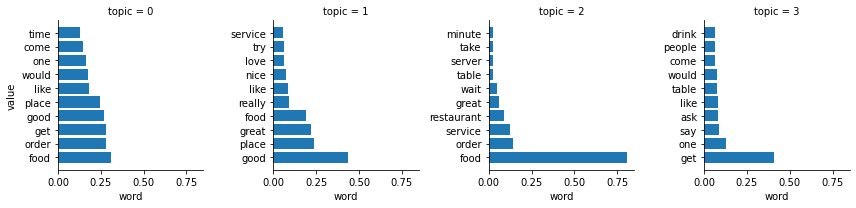

In [ ]:
# let's visulize it using seaborn
import seaborn as sns

g = sns.FacetGrid(topic_words, col="topic", col_wrap=4, sharey=False)
g.map(plt.barh, "word", "value")
# positive feedback, wonderful experience, food and order, asking for service

### LSA BOW model with 6 topics

In [ ]:
# the LSA model with 6 topics
%time gensim_lsa_6 = create_gensim_lsa_BOW(corpus, id2word, 6, 10)

print(gensim_lsa_6)

Topic  0 : 0.308*"food" + 0.281*"order" + 0.279*"get" + 0.270*"good" + 0.248*"place" + 0.179*"like" + 0.173*"would" + 0.165*"one" + 0.144*"come" + 0.130*"time"
Topic  1 : -0.608*"order" + 0.432*"good" + 0.230*"place" + 0.215*"great" + 0.189*"food" + -0.150*"get" + -0.150*"say" + -0.142*"ask" + -0.121*"take" + -0.119*"tell"
Topic  2 : 0.821*"food" + -0.261*"pizza" + -0.171*"like" + -0.167*"get" + -0.157*"good" + -0.133*"place" + 0.127*"service" + 0.108*"order" + -0.105*"one" + 0.085*"restaurant"
Topic  3 : -0.561*"order" + -0.487*"good" + 0.485*"get" + -0.232*"pizza" + 0.119*"one" + -0.090*"chicken" + 0.084*"say" + 0.075*"ask" + 0.071*"table" + 0.064*"people"
Topic  4 : 0.754*"place" + -0.416*"good" + -0.260*"get" + 0.247*"pizza" + 0.219*"great" + 0.112*"order" + -0.073*"chicken" + 0.068*"love" + -0.054*"would" + -0.045*"dish"
Topic  5 : 0.569*"pizza" + 0.514*"get" + 0.253*"good" + 0.204*"food" + -0.172*"like" + -0.145*"restaurant" + -0.138*"would" + -0.119*"dish" + -0.118*"one" + -0.10

In [ ]:
# let's create a dataframe that shows each topic, its top 10 words, and its value
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(gensim_lsa_6.get_topics()): # the term topic matrix with shape (num_topics, vocabulary_size)
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [id2word[id] for id in top_feature_ids]
    labels= [('Topic'+str(i)+' word'), ('Topic'+str(i)+' value') ]
    topic_df = pd.DataFrame(zip(words, feature_values), columns=labels)
    topic_words = pd.concat([topic_words, topic_df], axis=1)

topic_words

,Topic0 word,Topic0 value,Topic1 word,Topic1 value,Topic2 word,Topic2 value,Topic3 word,Topic3 value,Topic4 word,Topic4 value,Topic5 word,Topic5 value
0,food,0.307808,good,0.431869,food,0.821375,get,0.485096,place,0.754278,pizza,0.568795
1,order,0.280659,place,0.229947,service,0.127367,one,0.118808,pizza,0.247354,get,0.513998
2,get,0.278984,great,0.214788,order,0.108421,say,0.083688,great,0.219318,good,0.253446
3,good,0.270311,food,0.188837,restaurant,0.085485,ask,0.074889,order,0.112152,food,0.203787
4,place,0.247952,really,0.093070,great,0.065198,table,0.070825,love,0.067988,crust,0.044261
5,like,0.179207,like,0.090400,wait,0.050684,people,0.064498,best,0.037115,wait,0.042335
6,would,0.173288,nice,0.073353,table,0.030598,place,0.063672,always,0.035748,delivery,0.040188
7,one,0.165163,love,0.063939,server,0.028256,drink,0.063190,call,0.025392,cheese,0.036567
8,come,0.143687,try,0.060435,minute,0.027592,like,0.061772,delicious,0.023969,call,0.031540
9,time,0.129912,also,0.055886,take,0.027573,would,0.056747,delivery,0.023108,always,0.030648


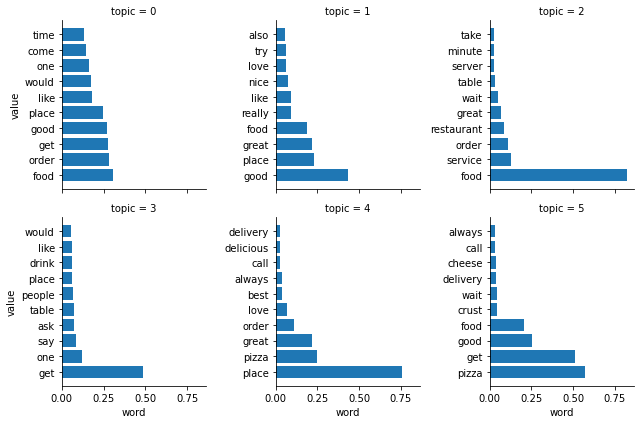

In [ ]:
# let's put this in only two columns so we can visulize it. 
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(gensim_lsa_6.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [id2word[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

g = sns.FacetGrid(topic_words, col="topic", col_wrap=3, sharey=False)
g.map(plt.barh, "word", "value")


### LSA BOW model with 8 topics

In [ ]:
# the LSA model with 8 topics
%time gensim_lsa_8 = create_gensim_lsa_BOW(corpus, id2word, 8, 10)

print(gensim_lsa_8)

Topic  0 : 0.308*"food" + 0.281*"order" + 0.279*"get" + 0.270*"good" + 0.248*"place" + 0.179*"like" + 0.173*"would" + 0.165*"one" + 0.144*"come" + 0.130*"time"
Topic  1 : -0.606*"order" + 0.436*"good" + 0.235*"place" + 0.214*"great" + 0.187*"food" + -0.150*"say" + -0.147*"get" + -0.142*"ask" + -0.121*"take" + -0.118*"tell"
Topic  2 : 0.819*"food" + -0.270*"pizza" + -0.174*"get" + -0.171*"good" + -0.164*"like" + -0.140*"place" + 0.126*"service" + 0.106*"order" + -0.102*"one" + 0.090*"restaurant"
Topic  3 : -0.563*"order" + -0.507*"good" + 0.438*"get" + -0.272*"pizza" + 0.129*"one" + 0.090*"like" + 0.085*"say" + 0.077*"table" + 0.076*"would" + 0.076*"ask"
Topic  4 : 0.777*"place" + -0.415*"good" + -0.222*"get" + 0.217*"pizza" + 0.205*"great" + 0.097*"order" + -0.084*"chicken" + 0.066*"love" + -0.057*"would" + -0.051*"dish"
Topic  5 : 0.681*"get" + 0.288*"pizza" + 0.231*"good" + -0.216*"like" + -0.190*"would" + -0.183*"restaurant" + 0.163*"food" + -0.129*"make" + -0.121*"dish" + -0.118*"o

In [ ]:
# let's create a dataframe that shows each topic, its top 10 words, and its value
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(gensim_lsa_8.get_topics()): # the term topic matrix with shape (num_topics, vocabulary_size)
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [id2word[id] for id in top_feature_ids]
    labels= [('Topic'+str(i)+' word'), ('Topic'+str(i)+' value') ]
    topic_df = pd.DataFrame(zip(words, feature_values), columns=labels)
    topic_words = pd.concat([topic_words, topic_df], axis=1)

topic_words

,Topic0 word,Topic0 value,Topic1 word,Topic1 value,Topic2 word,Topic2 value,Topic3 word,Topic3 value,Topic4 word,Topic4 value,Topic5 word,Topic5 value,Topic6 word,Topic6 value,Topic7 word,Topic7 value
0,food,0.307863,good,0.436366,food,0.818774,get,0.437535,place,0.777279,get,0.681496,order,0.350241,pizza,0.456916
1,order,0.280566,place,0.235127,service,0.126253,one,0.129446,pizza,0.217174,pizza,0.288129,get,0.286661,great,0.456314
2,get,0.278843,great,0.213832,order,0.106242,like,0.090143,great,0.204870,good,0.231388,chicken,0.184142,chicken,0.126380
3,good,0.270167,food,0.186855,restaurant,0.090254,say,0.085296,order,0.096594,food,0.163063,great,0.149965,delicious,0.117780
4,place,0.247814,really,0.092800,great,0.068422,table,0.077437,love,0.065580,place,0.095430,place,0.129204,sauce,0.109879
5,like,0.179308,like,0.087487,wait,0.048843,would,0.076486,always,0.036768,always,0.047192,also,0.099211,also,0.100295
6,would,0.173373,nice,0.072953,table,0.031129,ask,0.075815,best,0.034136,time,0.043208,sandwich,0.099135,fresh,0.096815
7,one,0.165203,love,0.063856,server,0.028881,come,0.065309,call,0.025695,great,0.038850,delicious,0.078343,love,0.095073
8,come,0.143709,try,0.059752,take,0.026682,people,0.062556,staff,0.022967,wait,0.033964,sauce,0.069455,make,0.092811
9,time,0.129886,service,0.055501,minute,0.025656,drink,0.062029,delivery,0.021880,delivery,0.028769,try,0.069050,like,0.090344


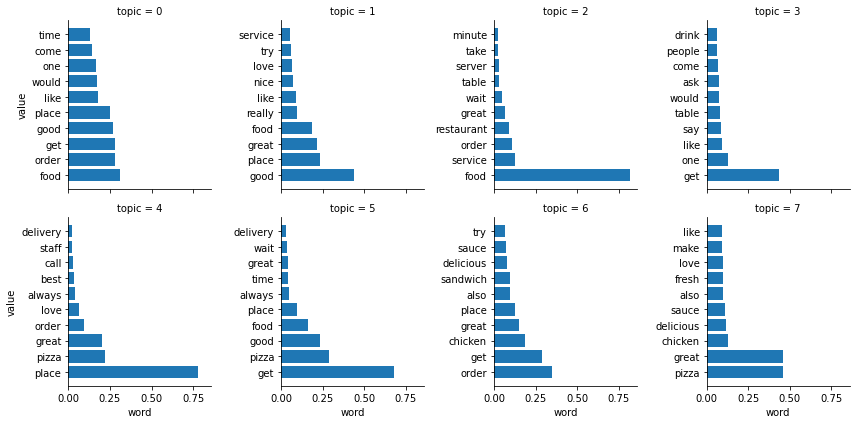

In [ ]:
# let's put this in only two columns so we can visulize it. 
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(gensim_lsa_8.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [id2word[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

g = sns.FacetGrid(topic_words, col="topic", col_wrap=4, sharey=False)
g.map(plt.barh, "word", "value")


### Discussion of the best model of LSA BOW
The best model of the LSA with BOW is the model with 4 topics. Compared to 6 topics and 8 topics, the model with 4 topics has the highest coherence score. Moreover, I can give these four topics clear labels for each of them. However, for 6 topics and 8 topics, there are some topics that overlap to each other. As a result, I would choose 4 topics as the best model for LSA with BOW.

### Lables for each topic
 - Topic 0: **Customer Experience** ("food", "order", "place", and "time" are all related to customer experience.)
 - Topic 1: **Positive Service** (It contains lots of positive words with "place" and "service")
 - Topic 2: **Wait time for Order** ("wait", "minute", "server", "order", "table", and "food" show the topic may be related to order time)
 - Topic 3: **Asking for Drink** ("get", "table", "ask", and "drink" can show the topic is for the waiter asking for drinks)


## Section 4: LSA with TF-IDF

In [ ]:
# vectorize the corpus using tfidf
tfidf = models.TfidfModel(corpus)

%time corpus_tfidf = tfidf[corpus]

CPU times: user 61 µs, sys: 0 ns, total: 61 µs
Wall time: 68.9 µs


### Select topic numbers based on coherence scores

In [ ]:
# Define evaluation model
def compute_coherence_scores_idf (id2word, corpus_tfidf, texts, stop, start, step):
  """
  Input:  id2word: a dictionary that maps token ID to tokens
          corpus_tfidf: output from TfidfModel 
          texts: a list of list strings, tokenized texts
          stop: Max number of topics 
          start: Min number of topics
          step: number of topics to increment 
  Output: model_list: a list of LSA topic models 
          coherence_score: a list of coherence scores for each topic model
  """
  coherence_score = []
  model_list = []

  for n_topics in range (start, stop, step):
    lsa_model = models.LsiModel(corpus_tfidf, # we will use tfidf
                                id2word=id2word,
                                num_topics=n_topics)
    
    model_list.append(lsa_model)
    
    coherence_model_lsa = CoherenceModel(model=lsa_model, texts=texts, dictionary=id2word, coherence='c_v')
    
    coherence_score.append(coherence_model_lsa.get_coherence())
  
  return model_list, coherence_score

In [ ]:
# we start with model with 2 topics, then with 4, 6, 8 topics, till with 10 topics 
%time lsa_tfidf_models = compute_coherence_scores_idf(id2word, corpus_tfidf, texts, stop=10, start=2, step=2)

CPU times: user 2min 52s, sys: 9.12 s, total: 3min 2s
Wall time: 2min 48s


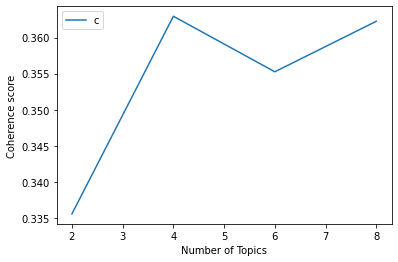

In [ ]:
# the plot shows that the number of topics based on coherence scores
x = range(2, 10, 2)
plt.plot(x, lsa_tfidf_models[1])
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### LSA TF-IDF model with 4 topics

In [ ]:
# Define LSA idf function
def create_gensim_lsa_idf (corpus_tfidf, id2word, n_topics, n_words):
  """
  Input: corpus_tf-idf, id2word, number of topics, and number of words for each topic
  output: return LSA model
  """
  lsa_model = models.LsiModel(corpus_tfidf,
                            id2word=id2word,
                            num_topics=n_topics)
  
  for index, value in lsa_model.print_topics(num_topics=n_topics, num_words=n_words):
    print('Topic ', index, ':', value)
  
  return lsa_model

In [ ]:
# the LSA model with 4 topics
%time gensim_lsa_idf_4 = create_gensim_lsa_idf(corpus_tfidf, id2word, 4, 10)

print(gensim_lsa_idf_4)

Topic  0 : 0.153*"order" + 0.149*"food" + 0.147*"good" + 0.140*"great" + 0.140*"place" + 0.139*"get" + 0.131*"pizza" + 0.115*"service" + 0.113*"like" + 0.110*"one"
Topic  1 : -0.859*"pizza" + -0.124*"crust" + -0.114*"delivery" + -0.108*"order" + 0.107*"sushi" + 0.096*"great" + -0.094*"cheese" + 0.083*"food" + -0.082*"slice" + -0.080*"call"
Topic  2 : 0.309*"pizza" + 0.279*"great" + -0.185*"order" + -0.166*"wait" + 0.162*"love" + -0.155*"minute" + 0.154*"delicious" + -0.145*"ask" + 0.138*"best" + -0.134*"say"
Topic  3 : 0.304*"great" + -0.285*"chicken" + 0.206*"always" + 0.204*"service" + -0.170*"sauce" + 0.164*"staff" + 0.153*"friendly" + 0.133*"food" + -0.126*"rice" + 0.124*"coffee"
CPU times: user 19.2 s, sys: 2.14 s, total: 21.4 s
Wall time: 17.7 s
LsiModel(num_terms=4068, num_topics=4, decay=1.0, chunksize=20000)


In [ ]:
# let's create a dataframe that shows each topic, its top 10 words, and its value
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(gensim_lsa_idf_4.get_topics()): # the term topic matrix with shape (num_topics, vocabulary_size)
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [id2word[id] for id in top_feature_ids]
    labels= [('Topic'+str(i)+' word'), ('Topic'+str(i)+' value') ]
    topic_df = pd.DataFrame(zip(words, feature_values), columns=labels)
    topic_words = pd.concat([topic_words, topic_df], axis=1)

topic_words

,Topic0 word,Topic0 value,Topic1 word,Topic1 value,Topic2 word,Topic2 value,Topic3 word,Topic3 value
0,order,0.152594,sushi,0.107001,pizza,0.309059,great,0.303914
1,food,0.148758,great,0.095738,great,0.278704,always,0.205602
2,good,0.146958,food,0.083169,love,0.162251,service,0.204224
3,great,0.140304,delicious,0.055432,delicious,0.154375,staff,0.164412
4,place,0.140256,nice,0.055350,best,0.137914,friendly,0.152926
5,get,0.138999,service,0.055200,fresh,0.125100,food,0.133322
6,pizza,0.131223,restaurant,0.052759,always,0.113046,coffee,0.124361
7,service,0.114867,burger,0.052705,sushi,0.106513,drink,0.118187
8,like,0.112542,coffee,0.050449,good,0.104060,love,0.100903
9,one,0.109569,dish,0.049779,friendly,0.098061,bar,0.098481


In [ ]:
# let's put this in only two columns so we can visulize it. 
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(gensim_lsa_idf_4.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [id2word[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

topic_words.head(15)

,value,word,topic
0,0.152594,order,0
1,0.148758,food,0
2,0.146958,good,0
3,0.140304,great,0
4,0.140256,place,0
5,0.138999,get,0
6,0.131223,pizza,0
7,0.114867,service,0
8,0.112542,like,0
9,0.109569,one,0


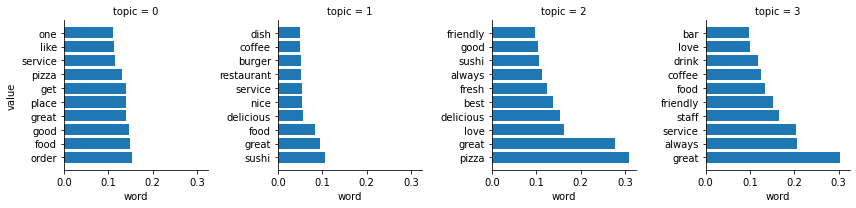

In [ ]:
# let's visulize it using seaborn
import seaborn as sns

g = sns.FacetGrid(topic_words, col="topic", col_wrap=4, sharey=False)
g.map(plt.barh, "word", "value")
# good experience, wonderful experience, food and service, appointment?

### LSA TF-IDF model with 6 topics

In [ ]:
# the LSA model with 6 topics
%time gensim_lsa_idf_6 = create_gensim_lsa_idf(corpus_tfidf, id2word, 6, 10)

print(gensim_lsa_idf_6)

Topic  0 : 0.153*"order" + 0.149*"food" + 0.147*"good" + 0.140*"place" + 0.140*"great" + 0.139*"get" + 0.131*"pizza" + 0.115*"service" + 0.113*"like" + 0.110*"one"
Topic  1 : -0.855*"pizza" + -0.122*"crust" + -0.117*"delivery" + -0.114*"order" + 0.100*"sushi" + 0.097*"great" + -0.094*"cheese" + 0.083*"food" + -0.083*"call" + -0.082*"slice"
Topic  2 : 0.321*"pizza" + 0.277*"great" + -0.187*"order" + -0.167*"wait" + 0.159*"love" + -0.155*"minute" + 0.152*"delicious" + -0.147*"ask" + 0.135*"best" + -0.134*"tell"
Topic  3 : 0.308*"great" + -0.283*"chicken" + 0.221*"always" + 0.202*"service" + -0.180*"sauce" + 0.166*"staff" + 0.151*"friendly" + 0.138*"coffee" + -0.132*"rice" + 0.124*"food"
Topic  4 : -0.701*"sushi" + 0.317*"sandwich" + -0.284*"roll" + 0.168*"burger" + 0.142*"chicken" + 0.110*"coffee" + -0.110*"restaurant" + 0.105*"fry" + 0.099*"always" + -0.094*"fish"
Topic  5 : -0.499*"burger" + 0.332*"sandwich" + 0.239*"sushi" + 0.228*"always" + -0.174*"bar" + -0.170*"fry" + -0.159*"drink

In [ ]:
# let's create a dataframe that shows each topic, its top 10 words, and its value
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(gensim_lsa_idf_6.get_topics()): # the term topic matrix with shape (num_topics, vocabulary_size)
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [id2word[id] for id in top_feature_ids]
    labels= [('Topic'+str(i)+' word'), ('Topic'+str(i)+' value') ]
    topic_df = pd.DataFrame(zip(words, feature_values), columns=labels)
    topic_words = pd.concat([topic_words, topic_df], axis=1)

topic_words

,Topic0 word,Topic0 value,Topic1 word,Topic1 value,Topic2 word,Topic2 value,Topic3 word,Topic3 value,Topic4 word,Topic4 value,Topic5 word,Topic5 value
0,order,0.152631,sushi,0.099773,pizza,0.321471,great,0.308436,sandwich,0.317273,sandwich,0.332140
1,food,0.148825,great,0.097211,great,0.277295,always,0.220968,burger,0.167890,sushi,0.239273
2,good,0.146951,food,0.083296,love,0.158636,service,0.201587,chicken,0.141505,always,0.228333
3,place,0.140204,delicious,0.057198,delicious,0.151783,staff,0.165588,coffee,0.110462,bagel,0.137870
4,great,0.140171,service,0.056513,best,0.134950,friendly,0.150837,fry,0.105235,love,0.127678
5,get,0.138977,nice,0.055625,fresh,0.119716,coffee,0.138327,always,0.099100,order,0.116628
6,pizza,0.131317,coffee,0.053877,always,0.105500,food,0.123555,cheese,0.084690,fresh,0.116028
7,service,0.114856,dish,0.053300,good,0.105269,love,0.116406,love,0.084680,roll,0.108662
8,like,0.112567,restaurant,0.051608,friendly,0.097339,drink,0.108506,bagel,0.084490,coffee,0.099446
9,one,0.109541,chicken,0.049529,sushi,0.091013,location,0.106945,breakfast,0.079835,sub,0.099002


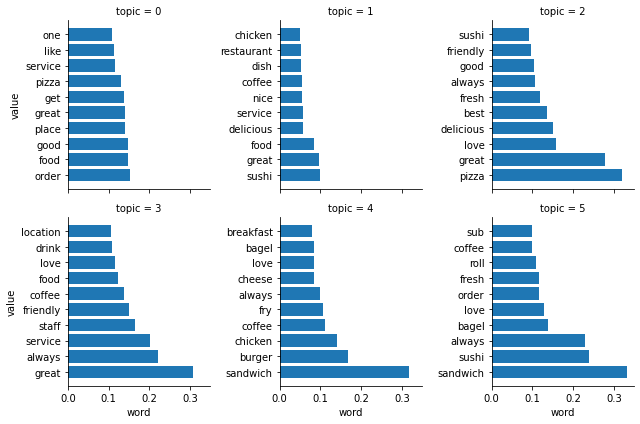

In [ ]:
# let's put this in only two columns so we can visulize it. 
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(gensim_lsa_idf_6.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [id2word[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

g = sns.FacetGrid(topic_words, col="topic", col_wrap=3, sharey=False)
g.map(plt.barh, "word", "value")


### LSA TF-IDF model with 8 topics

In [ ]:
# the LSA model with 8 topics
%time gensim_lsa_idf_8 = create_gensim_lsa_idf(corpus_tfidf, id2word, 8, 10)

print(gensim_lsa_idf_8)

Topic  0 : 0.153*"order" + 0.149*"food" + 0.147*"good" + 0.140*"place" + 0.140*"great" + 0.139*"get" + 0.132*"pizza" + 0.115*"service" + 0.113*"like" + 0.110*"one"
Topic  1 : -0.883*"pizza" + -0.128*"crust" + -0.116*"delivery" + -0.099*"cheese" + -0.092*"order" + 0.092*"sushi" + -0.083*"slice" + 0.081*"food" + -0.075*"topping" + -0.074*"call"
Topic  2 : 0.281*"great" + 0.230*"pizza" + -0.198*"order" + -0.170*"wait" + 0.164*"love" + -0.161*"minute" + 0.158*"delicious" + -0.148*"ask" + -0.137*"tell" + 0.137*"best"
Topic  3 : 0.308*"great" + -0.277*"chicken" + 0.224*"always" + 0.197*"service" + -0.173*"sauce" + 0.162*"staff" + 0.154*"friendly" + 0.149*"coffee" + -0.127*"rice" + 0.124*"food"
Topic  4 : -0.759*"sushi" + -0.311*"roll" + 0.224*"sandwich" + 0.161*"burger" + 0.119*"chicken" + 0.113*"coffee" + -0.105*"restaurant" + 0.104*"fry" + 0.102*"taco" + -0.097*"fish"
Topic  5 : 0.362*"always" + -0.260*"burger" + -0.214*"bar" + -0.208*"drink" + 0.178*"sandwich" + 0.174*"order" + 0.171*"lov

In [ ]:
# let's create a dataframe that shows each topic, its top 10 words, and its value
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(gensim_lsa_idf_8.get_topics()): # the term topic matrix with shape (num_topics, vocabulary_size)
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [id2word[id] for id in top_feature_ids]
    labels= [('Topic'+str(i)+' word'), ('Topic'+str(i)+' value') ]
    topic_df = pd.DataFrame(zip(words, feature_values), columns=labels)
    topic_words = pd.concat([topic_words, topic_df], axis=1)

topic_words

,Topic0 word,Topic0 value,Topic1 word,Topic1 value,Topic2 word,Topic2 value,Topic3 word,Topic3 value,Topic4 word,Topic4 value,Topic5 word,Topic5 value,Topic6 word,Topic6 value,Topic7 word,Topic7 value
0,order,0.152634,sushi,0.091645,great,0.280944,great,0.307950,sandwich,0.223608,always,0.361776,sandwich,0.398873,burger,0.658127
1,food,0.148766,food,0.080823,pizza,0.229883,always,0.223734,burger,0.161364,sandwich,0.177673,coffee,0.301161,sandwich,0.329256
2,good,0.146996,great,0.070014,love,0.164076,service,0.196637,chicken,0.118920,order,0.173908,sushi,0.213326,fry,0.285906
3,place,0.140242,restaurant,0.052170,delicious,0.158446,staff,0.161980,coffee,0.112687,love,0.170969,bagel,0.181508,sushi,0.216397
4,great,0.140221,service,0.052098,best,0.136539,friendly,0.153790,fry,0.103527,chicken,0.154657,breakfast,0.122115,order,0.096531
5,get,0.139005,burger,0.049118,fresh,0.123442,coffee,0.148853,taco,0.101502,best,0.154390,roll,0.111002,great,0.096385
6,pizza,0.131502,dish,0.048190,good,0.107769,food,0.124114,breakfast,0.085640,fresh,0.125816,bread,0.104860,roll,0.095519
7,service,0.114806,nice,0.046347,sushi,0.107643,love,0.114465,cheese,0.084689,burrito,0.118725,make,0.078361,fast,0.068520
8,like,0.112561,coffee,0.045699,always,0.106297,drink,0.112265,bagel,0.061825,taco,0.117444,sub,0.078359,bun,0.065244
9,one,0.109517,breakfast,0.041677,friendly,0.098791,location,0.103293,bread,0.060987,location,0.115365,work,0.076575,sub,0.063470


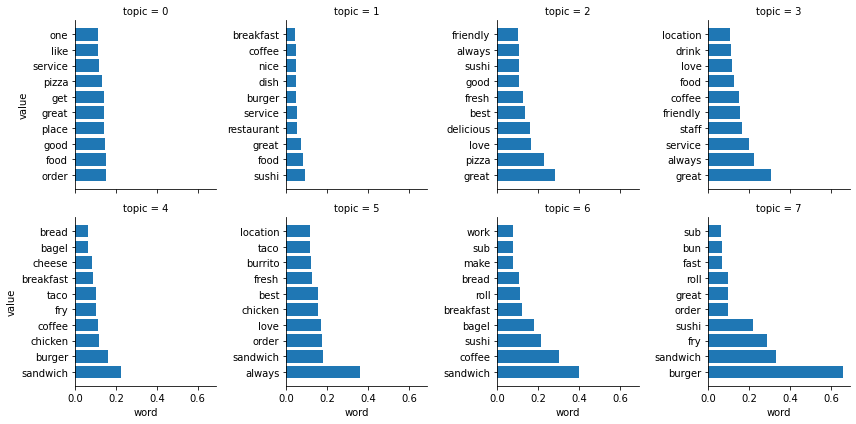

In [ ]:
# let's put this in only two columns so we can visulize it. 
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(gensim_lsa_idf_8.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [id2word[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

g = sns.FacetGrid(topic_words, col="topic", col_wrap=4, sharey=False)
g.map(plt.barh, "word", "value")


### Discussion of the best model of LSA TF-IDF
The best model would be selected from either 4 topics or 8 topics since they have higher coherence scores than the model with 6 topics. Within the four topics in the 4 topics model, there are two topics I am not able to give labels because they contain quite different elements. For example, the topic 2 model includes "pizza", "sushi", "fresh", "delicious", and "friendly". These words may relate to service, good food, pizza house, and Japanese restaurant, so I could not give them a specific label. Although the model for 8 topics has a similar situation, it still contains more clear topics than the 4 topics model. As a result, I would select 8 topics as the best model of LSA TF-IDF.
### Lables for each topic
 - Topic 0: **Customer Experience** ("food", "order", "place", and "service" are all related to customer experience.)
 - Topic 1: **Unable to label** ("food", "service", and "restaurant" may be related to customer experience, but it also contains "burger", "sushi", and "breakfast" that are belongs to different kinds of restaurants. Hence, I could not give it a specific label.)
 - Topic 2: **Unable to label** (It includes "pizza", "sushi", "fresh", "delicious", and "friendly". These words may relate to service, good food, pizza house, and Japanese restaurant, so I could not give it a specific label.)
 - Topic 3: **Cafe Service** (staff, service, and friendly reflect the topic would be related to service and drink and coffee show it may be a cafe)
 - Topic 4: **Fast Food Restaurant** ("Burger", "sandwich", "fry", "taco")
 - Topic 5: **Mexico Restaurant** ("taco", "burrito", "chicken", "sandwich")
 - Topic 6: **Breakfast versus Japanese Restaurant** ("breakfast", "sandwich", "coffee", "bagel", and "bread" are related to breakfast but it also contains "sushi" and "roll". "sub" can demonstrate people substitute one for the other.)
 - Topic 7: **American Restaurant versus Japanese Restaurant** ("Burger", "sandwich", are "fry" are related to American Restaurant but it also contains "sushi" and "roll". "sub" can demonstrate people substitute one for the other.)


## Section 5: LDA

In [ ]:
!pip install --update gensim # you may need to update gensim 
!pip install -q pyLDAvis # for visualization
!pip install --upgrade pandas==1.2 # need update colab pandas to version 1.2 so later visualization will work. 


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --update
     |████████████████████████████████| 1.7 MB 4.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 5.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [ ]:
# save processed data objects
#import cPickle as pickle

# gensim for LDA
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.corpora import MmCorpus
from gensim.models import CoherenceModel # for evaluation

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim_models

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
# Define LDA function
def compute_lda_coherence_scores (id2word, texts, corpus, stop, start, step):
  
  """
  Input:  id2word: a dictionary that maps token ID to tokens
          texts: a list of list strings
          corpus: Gensim corpus which is a BOW model with bigrams
          stop: Max number of topics 
          start: Min number of topics
          step: number of topics to increment 
  Output: model_list: a list of LDA topic models 
          coherence_score: a list of coherence scores for each topic model
  """
  coherence_score = []
  model_list = []

  for n_topics in range (start, stop, step):
    chunksize = 1500
    passes = 20
    iterations = 400 # we increase its iterations
    eval_every = None  # 
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=n_topics, 
                                            random_state=777,
                                            chunksize=chunksize,
                                            passes=passes,
                                            alpha='auto',
                                            eta ='auto',
                                            iterations = iterations,
                                            gamma_threshold=0.001,
                                            per_word_topics=True,
                                            eval_every = eval_every)
    
    model_list.append(lda_model)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    
    coherence_score.append(coherence_model_lda.get_coherence())
  
  return model_list, coherence_score

In [ ]:
# this runs about 10 minutes, be patients
%time lda_models = compute_lda_coherence_scores (id2word, texts, corpus, stop=18, start=4, step=2)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


CPU times: user 43min 51s, sys: 16.3 s, total: 44min 7s
Wall time: 44min 8s


In [ ]:
lda_models[1]

[0.42738846557533877,
 0.4597858930174082,
 0.44053214554922737,
 0.4364425890158475,
 0.46084110056058064,
 0.4454675803816815,
 0.43403775280079104]

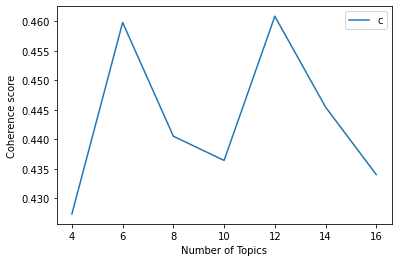

In [ ]:
# the plot shows that the number of topics based on coherence score is actually 6 or 12. 
x = range(4, 18, 2)
plt.plot(x, lda_models[1])
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# we see that there is 12 topics
# you may create a function that is similar to 1.6 to get the topic printout
num_topics = 12
chunksize = 1500
passes = 20
iterations = 400
eval_every = None  

# train LDA model 
import time 
start = time.time()

lda_model_12 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num_topics, 
                                            random_state=777,
                                            chunksize=chunksize,
                                            passes=passes,
                                            alpha='auto',
                                            eta ='auto',
                                            iterations = iterations,
                                            gamma_threshold=0.001,
                                            per_word_topics=True,
                                            eval_every = eval_every)

print('training time in second', (time.time() - start))

training time in second 360.16543459892273


In [ ]:
# default print topic
# we can see the topic is much easier to interpret, partly because of LAD algroithm, partly because we filtered extreme words
for index, value in lda_model_12.print_topics():
  print('Topic ', index, ':', value)

Topic  0 : 0.025*"like" + 0.024*"good" + 0.022*"get" + 0.016*"one" + 0.015*"really" + 0.015*"would" + 0.014*"make" + 0.013*"eat" + 0.012*"try" + 0.012*"well"
Topic  1 : 0.039*"ice_cream" + 0.037*"cake" + 0.028*"pasta" + 0.027*"chocolate" + 0.026*"flavor" + 0.025*"gelato" + 0.022*"italian" + 0.022*"sweet" + 0.019*"bakery" + 0.018*"soft_serve"
Topic  2 : 0.049*"order" + 0.023*"time" + 0.021*"get" + 0.021*"say" + 0.018*"take" + 0.014*"food" + 0.014*"back" + 0.014*"come" + 0.013*"ask" + 0.013*"wait"
Topic  3 : 0.340*"pizza" + 0.081*"delivery" + 0.079*"wing" + 0.045*"sub" + 0.041*"slice" + 0.040*"crust" + 0.034*"topping" + 0.027*"cheese" + 0.019*"deliver" + 0.018*"pie"
Topic  4 : 0.237*"location" + 0.079*"employee" + 0.075*"store" + 0.026*"drive_thru" + 0.021*"consistent" + 0.015*"hair" + 0.014*"worst" + 0.013*"domino" + 0.012*"nasty" + 0.012*"syrup"
Topic  5 : 0.053*"spicy" + 0.053*"bowl" + 0.048*"taco" + 0.047*"rice" + 0.040*"beef" + 0.037*"soup" + 0.034*"burrito" + 0.032*"pork" + 0.025*"

In [ ]:
# let's visualize the result using pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_12, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.304388  0.007950       1        1  33.796134
2     -0.299936 -0.007369       2        1  24.901472
6     -0.254628  0.000620       3        1  18.591614
11     0.090397  0.226479       4        1   6.099024
9     -0.071889  0.048625       5        1   5.339991
5      0.148175  0.147223       6        1   2.438643
8      0.122379 -0.012717       7        1   2.251219
1      0.135894  0.115612       8        1   1.744179
10     0.112361 -0.183569       9        1   1.367682
4      0.092928 -0.365195      10        1   1.247262
3      0.106600  0.047996      11        1   1.217844
7      0.122107 -0.025655      12        1   1.004937, topic_info=                    Term          Freq         Total Category  logprob  \
66                 pizza  11232.000000  11232.000000  Default  30.0000   
33                  food  42567.000000  42567.000000  Default  29.0000   
263                order  34876.000000  34876.000000  Default  28.0000   
10                 great  23610.000000  23610.000000  Default  27.0000   
47                 place  35833.000000  35833.000000  Default  26.0000   
156             location   8032.000000   8032.000000  Default  25.0000   
349              chicken  11271.000000  11271.000000  Default  24.0000   
34                  good  37574.000000  37574.000000  Default  23.0000   
152                 like  22506.000000  22506.000000  Default  22.0000   
633             sandwich   6401.000000   6401.000000  Default  21.0000   
291                sushi   4663.000000   4663.000000  Default  20.0000   
394                sauce   7921.000000   7921.000000  Default  19.0000   
276           restaurant  13392.000000  13392.000000  Default  18.0000   
50               service  17627.000000  17627.000000  Default  17.0000   
87                  love  11807.000000  11807.000000  Default  16.0000   
432                 menu   9673.000000   9673.000000  Default  15.0000   
278                 roll   4212.000000   4212.000000  Default  14.0000   
91                   say  14013.000000  14013.000000  Default  13.0000   
437                salad   6738.000000   6738.000000  Default  12.0000   
567                  fry   6545.000000   6545.000000  Default  11.0000   
9                    get  34252.000000  34252.000000  Default  10.0000   
83                 fresh   8487.000000   8487.000000  Default   9.0000   
210                 time  17269.000000  17269.000000  Default   8.0000   
261                 nice  10707.000000  10707.000000  Default   7.0000   
1024              coffee   4519.000000   4519.000000  Default   6.0000   
206                 take  12218.000000  12218.000000  Default   5.0000   
310                 dish   6504.000000   6504.000000  Default   4.0000   
60             delicious   9955.000000   9955.000000  Default   3.0000   
0                 always   8965.000000   8965.000000  Default   2.0000   
577                 side   5787.000000   5787.000000  Default   1.0000   
152                 like  22506.413200  22506.555649   Topic1  -3.7078   
260                 much   7587.399604   7587.538016   Topic1  -4.7951   
270               pretty   6627.036999   6627.175013   Topic1  -4.9305   
197                small   6512.116287   6512.260825   Topic1  -4.9480   
826               expect   3855.808032   3855.947379   Topic1  -5.4720   
246               enough   3921.298671   3921.452212   Topic1  -5.4552   
293               though   3443.532093   3443.668898   Topic1  -5.5851   
526            different   3406.928640   3407.066026   Topic1  -5.5958   
944             probably   3337.807157   3337.944970   Topic1  -5.6163   
150                 item   2945.707538   2945.849363   Topic1  -5.7413   
351               decent   2589.829638   2589.966016   Topic1  -5.8700   
983                  old   2463.717328   2463.859969   Topic1  -5.9200   
807                

In [ ]:
# we see that there is 6 topics
# you may create a function that is similar to 1.6 to get the topic printout
num_topics = 6
chunksize = 1500
passes = 20
iterations = 400
eval_every = None  

# train LDA model 
import time 
start = time.time()

lda_model_6 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num_topics, 
                                            random_state=777,
                                            chunksize=chunksize,
                                            passes=passes,
                                            alpha='auto',
                                            eta ='auto',
                                            iterations = iterations,
                                            gamma_threshold=0.001,
                                            per_word_topics=True,
                                            eval_every = eval_every)

print('training time in second', (time.time() - start))

training time in second 376.95028829574585


In [ ]:
# default print topic
# we can see the topic is much easier to interpret, partly because of LAD algroithm, partly because we filtered extreme words
for index, value in lda_model_6.print_topics():
  print('Topic ', index, ':', value)

Topic  0 : 0.036*"good" + 0.024*"like" + 0.023*"place" + 0.018*"get" + 0.015*"really" + 0.014*"one" + 0.014*"would" + 0.013*"food" + 0.012*"well" + 0.011*"try"
Topic  1 : 0.053*"great" + 0.043*"food" + 0.029*"place" + 0.027*"love" + 0.025*"service" + 0.022*"delicious" + 0.020*"always" + 0.020*"best" + 0.016*"nice" + 0.014*"friendly"
Topic  2 : 0.026*"drink" + 0.023*"table" + 0.018*"bar" + 0.017*"friend" + 0.015*"come" + 0.015*"server" + 0.011*"restaurant" + 0.010*"sit" + 0.010*"night" + 0.010*"waitress"
Topic  3 : 0.150*"pizza" + 0.094*"sandwich" + 0.058*"cheese" + 0.038*"salad" + 0.035*"wing" + 0.033*"bread" + 0.028*"slice" + 0.026*"bagel" + 0.023*"topping" + 0.020*"sub"
Topic  4 : 0.049*"order" + 0.027*"get" + 0.023*"say" + 0.022*"time" + 0.019*"food" + 0.019*"take" + 0.015*"ask" + 0.015*"wait" + 0.013*"back" + 0.013*"never"
Topic  5 : 0.036*"chicken" + 0.023*"sauce" + 0.021*"dish" + 0.018*"fry" + 0.016*"flavor" + 0.016*"order" + 0.015*"meat" + 0.013*"salad" + 0.013*"taste" + 0.012*"

In [ ]:
# let's visualize the result using pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_6, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.178879 -0.031817       1        1  35.111475
4      0.188769  0.085082       2        1  22.604065
1      0.108241 -0.307929       3        1  16.185457
2      0.130787  0.261114       4        1  12.090303
5     -0.207946 -0.072131       5        1  11.202735
3     -0.398729  0.065680       6        1   2.805965, topic_info=                  Term          Freq         Total Category  logprob  loglift
10               great  23436.000000  23436.000000  Default  30.0000  30.0000
66               pizza  11412.000000  11412.000000  Default  29.0000  29.0000
263              order  34942.000000  34942.000000  Default  28.0000  28.0000
33                food  42865.000000  42865.000000  Default  27.0000  27.0000
34                good  38053.000000  38053.000000  Default  26.0000  26.0000
633           sandwich   7142.000000   7142.000000  Default  25.0000  25.0000
349            chicken  10855.000000  10855.000000  Default  24.0000  24.0000
47               place  36209.000000  36209.000000  Default  23.0000  23.0000
152               like  22625.000000  22625.000000  Default  22.0000  22.0000
87                love  11720.000000  11720.000000  Default  21.0000  21.0000
91                 say  14111.000000  14111.000000  Default  20.0000  20.0000
62               drink   8666.000000   8666.000000  Default  19.0000  19.0000
437              salad   6819.000000   6819.000000  Default  18.0000  18.0000
469             cheese   5211.000000   5211.000000  Default  17.0000  17.0000
60           delicious   9877.000000   9877.000000  Default  16.0000  16.0000
50             service  17614.000000  17614.000000  Default  15.0000  15.0000
9                  get  34352.000000  34352.000000  Default  14.0000  14.0000
1                 best   8723.000000   8723.000000  Default  13.0000  13.0000
0               always   8899.000000   8899.000000  Default  12.0000  12.0000
206               take  12313.000000  12313.000000  Default  11.0000  11.0000
292              table   7417.000000   7417.000000  Default  10.0000  10.0000
394              sauce   7689.000000   7689.000000  Default   9.0000   9.0000
210               time  17437.000000  17437.000000  Default   8.0000   8.0000
273             really  14488.000000  14488.000000  Default   7.0000   7.0000
310               dish   6265.000000   6265.000000  Default   6.0000   6.0000
101                ask   9135.000000   9135.000000  Default   5.0000   5.0000
296               wait   9008.000000   9008.000000  Default   4.0000   4.0000
233                bar   5975.000000   5975.000000  Default   3.0000   3.0000
276         restaurant  13674.000000  13674.000000  Default   2.0000   2.0000
165              never   7897.000000   7897.000000  Default   1.0000   1.0000
260               much   7630.353324   7630.505606   Topic1  -4.8277   1.0466
270             pretty   6664.554259   6664.687853   Topic1  -4.9630   1.0466
291              sushi   4325.153076   4325.285156   Topic1  -5.3954   1.0466
48             quality   3694.457438   3694.589025   Topic1  -5.5530   1.0466
293             though   3463.033393   3463.165514   Topic1  -5.6177   1.0466
909               kind   4098.859625   4099.044931   Topic1  -5.4491   1.0466
351             decent   2604.499001   2604.629557   Topic1  -5.9026   1.0466
807               high   2178.930614   2179.059577   Topic1  -6.0810   1.0466
119              cheap   1981.915820   1982.045407   Topic1  -6.1757   1.0466
1228             might   1912.191174   1912.320117   Topic1  -6.2116   1.0466
204              stuff   1848.480186   1848.610597   Topic1  -6.2454   1.0466
1741             crepe   1688.414197   1688.537588   Topic1  -6.3360   1.0466
1447           average   1589.620176   1589.748979   Topic1  -6.3963   1.0466
731               type   1520.334177   1520.462121   Topic1  -6.4409   1.0466
930          ex

### Discussion of the best model of LDA
The overall coherence score of LDA models is pretty good. Especially, the model with 6 topics and the model with 12 topics are way better than the other models. From the visualization, we can see each topic in the 6 topics model is separated well and it is expected to get clear labels from each of them. However, the model with 12 topics performs better. Although there is some overlap, we still can find at least 8 different parts in the visualization and is more than 6 topics. Besides, even though topics overlap, each of them shows clear topics from those words. I think the topics in 12 ones are clearer and easier to identify than those topics in the 6 topics model. Therefore, I would choose 12 topics as the best model in LDA.
### Lables for each topic
 - Topic 1: Customer Experience
 - Topic 2: Order Waiting Time
 - Topic 3: Food
 - Topic 4: Amercian Restaurant
 - Topic 5: Seafood Restaurant
 - Topic 6: Mexican Restaurant
 - Topic 7: Breakfast
 - Topic 8: Ice Cream
 - Topic 9: Chinese Restaurant
 - Topic 10: Restaurant Accessbility
 - Topic 11: Pizza House
 - Topic 12: Janpanese Restaurant

## Section 6: Best model selection

The best model of each part is listed below:
- LSA using BOW
- LSA using TF-IDF 8 topics model
- LDA 12 topics model

From the coherence score aspect, the LDA model dominates and gets a much higher score than the LSA models. In other words, it shows better classification abilities in the corpus to get those topics. Moreover, each topic from the LDA model is clear and obvious and is separated clearly. I can immediately get an idea of each topic from those words. However, the topics from the LSA model usually overlap with each other a lot and are not specific enough to come up with ideas for the topics. As a result, I would choose LDA 12 topics model to be the best model in this case.